# k= 32 L2: 7.4614e-05 H1: 5.2804e-03 Li: 7.5053e-04


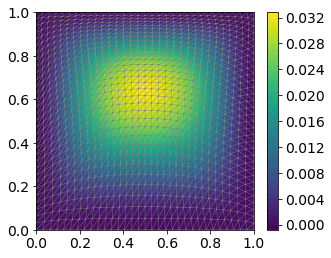

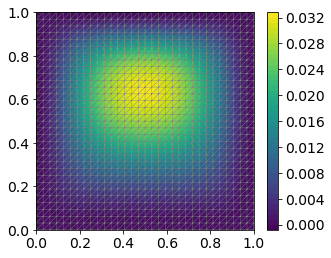

In [54]:
from fenics import *
from mshr import *
import numpy as np
from pylab import plt
import logging
import csv

from utils import *

# Remove unwanted warning messages from the output
logging.getLogger('FFC').setLevel(logging.WARNING)

parameters["form_compiler"]["quadrature_degree"] = 5

# ------------------------------------

k           = 32
mu          = 1.0   # Lame constant
lmbda       = 2.0   # Lame constant
f0          = 6.0   # gravity
NEWTON_tol  = 1e-8  # tolerance of Newton iterative solver
dim         = 2     # spatial dimension

ELEMENT     = {1:interval,2:triangle}

FE          = VectorElement('P',ELEMENT[dim], 2)

meshbar     = UnitSquareMesh(k,k) # Generation of Lagrangian mesh
mesh        = UnitSquareMesh(k,k) # Generation of Eulerian mesh

Wbar  = get_space(meshbar,FE)   # Lagrangian state space 
W     = get_space(mesh   ,FE)   # Eulerian state space

bcbar = DirichletBC(Wbar, Constant((0, 0)) , 'on_boundary')
bc    = DirichletBC(W   , Constant((0, 0)) , 'on_boundary')

f     = Expression(('0','f0'),f0=f0,degree=2)

def energybar(qbar):
    xbar = SpatialCoordinate(meshbar)
    I    = Identity(dim)
    Fbar = I + grad(qbar)
    Cbar = Fbar.T*Fbar
    Jbar = det(Fbar)
    Ebar = mu/2*(tr(Cbar-I) - 2*ln(Jbar)) + lmbda/2*(Jbar-1)**2 - inner(f,xbar+qbar)
    return Ebar

def energy(q):
    x = SpatialCoordinate(mesh)
    I = Identity(dim)
    F = inv(I - grad(q))
    C = F.T*F
    J = det(F)
    E = ( mu/2*(tr(C-I) - 2*ln(J)) + lmbda/2*(J-1)**2 - inner(f,x) ) / J
    return E
    
qbar   = Function(Wbar)
Ebar   = energybar(qbar)*dx
Resbar = derivative(Ebar,qbar)

solve(Resbar==0,qbar,bcbar,solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})

q   = Function(W)
E   = energy(q)*dx
Res = derivative(E,q)

solve(Res==0,q,bc,solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})


ALE.move(meshbar,qbar)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})

cbar = plot(inner(qbar,qbar))
plot(qbar)
plot(meshbar,linewidth=0.4)
plt.colorbar(cbar, fraction=0.046, pad=0.04)

plt.savefig('media/stationary_sol_Lagrange.png',dpi=300)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})

c = plot(inner(q,q))
plot(q)
plot(mesh,linewidth=0.4)
plt.colorbar(c, fraction=0.046, pad=0.04)

plt.savefig('media/stationary_sol_Euler.png',dpi=300)


qbari = project(qbar     ,W,bcs=bc,solver_type='cg')
erri  = project(q - qbari,W,bcs=bc,solver_type='cg')

L2err  = norm(erri, 'l2')
H1err  = norm(erri, 'h1')
Lierr  = norm(erri.vector(), 'linf')

print(f'# k={k:3} L2: {L2err:.4e} H1: {H1err:.4e} Li: {Lierr:.4e}')

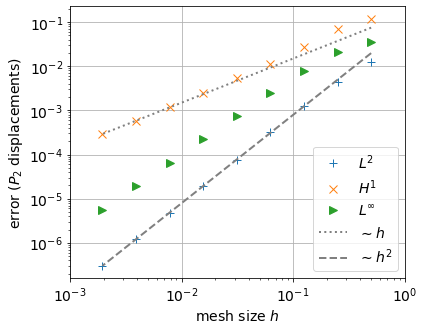

In [53]:
import numpy as np
from pylab import plt

# convergence for P2 displacements
# k=  2 L2: 1.2401e-02 H1: 1.1854e-01 Li: 3.5739e-02
# k=  4 L2: 4.4063e-03 H1: 6.8382e-02 Li: 2.0545e-02
# k=  8 L2: 1.2282e-03 H1: 2.7894e-02 Li: 7.8188e-03
# k= 16 L2: 3.1654e-04 H1: 1.1182e-02 Li: 2.4954e-03
# k= 32 L2: 7.4658e-05 H1: 5.2901e-03 Li: 7.5060e-04
# k= 64 L2: 1.9541e-05 H1: 2.4590e-03 Li: 2.2155e-04
# k=128 L2: 4.8303e-06 H1: 1.1985e-03 Li: 6.4999e-05
# k=256 L2: 1.2119e-06 H1: 5.8740e-04 Li: 1.9033e-05
# k=512 L2: 3.0127e-07 H1: 2.9089e-04 Li: 5.5969e-06

k = [2,4,8,16,32,64,128,256,512]
h = np.divide(1,k)

L2_errs = [1.2401e-02,4.4063e-03,1.2282e-03,3.1654e-04,7.4658e-05,1.9541e-05,4.8303e-06,1.2119e-06,3.0127e-07]
H1_errs = [1.1854e-01,6.8382e-02,2.7894e-02,1.1182e-02,5.2901e-03,2.4590e-03,1.1985e-03,5.8740e-04,2.9089e-04]
Li_errs = [3.5739e-02,2.0545e-02,7.8188e-03,2.4954e-03,7.5060e-04,2.2155e-04,6.4999e-05,1.9033e-05,5.5969e-06]

plt.figure(figsize=(6,5))

plt.rcParams.update({'font.size': 14})

plt.loglog(h,L2_errs,'+',label='$L^2$',markersize=8)
plt.loglog(h,H1_errs,'x',label='$H^1$',markersize=8)
plt.loglog(h,Li_errs,'>',label='$L^\infty$',markersize=8)

L2scal = L2_errs[-1]/h[-1]**2
H1scal = H1_errs[-1]/h[-1]
Liscal = Li_errs[-1]/h[-1]**1.75

plt.plot(h,np.multiply(np.power(h,1),H1scal),':',color=[0.5,0.5,0.5],label='$\sim h$',linewidth=2)
plt.plot(h,np.multiply(np.power(h,2),L2scal),'--',color=[0.5,0.5,0.5],label='$\sim h^2$',linewidth=2)
# plt.plot(h,np.multiply(np.power(h,1.75),Liscal),'--',color=[0.5,0.5,0.5])
plt.xlim([1e-3,1])
plt.legend()
plt.xlabel('mesh size $h$')
plt.ylabel('error ($P_2$ displacements)')

plt.grid(True)

plt.savefig('media/stationary_convergence.pdf')